In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

2024-04-24 12:19:39.959323: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-24 12:19:40.111867: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-24 12:19:40.769422: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 12:19:43.920852: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Task 1

In [2]:
# load the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# scale the data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [3]:
# matrix into vector
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [4]:
original_dim = x_train.shape[1]

## a)

From the lecture we know that ELBO equals

$$ELBO = \mathbb{E}_q \log p(x|z) - KL(q(z|x)||p(z)).$$

Assume that we already know the parameters of the encoder 

$$\mathbb{E}_q \log p(x|z) = \mathbb{E}_{\varepsilon} \log p(x|z_{\phi}(\varepsilon, x))$$

Below: 

 - `x` - observed vector of pixels (0 and 1)
 - `x_decoded` - $p(1|z_{\phi}(\varepsilon, x)) = p(1|\mu_{\phi}(x) + \Sigma_{\phi}(x)^{1/2}\varepsilon)$, where $\varepsilon$ was generated according to $\mathcal{N}(0, 1)$ - the aposteriori probability of the pixel being $1$ after reparametrization trick
 - $\Sigma_{\phi}(x) = \textrm{diag}(\sigma_{\phi, 1}^2(x), \sigma_{\phi, 2}^2, \ldots, \sigma_{\phi, K}^2)$
 - `z_mean` - $\mu_{\phi}(x) = (\mu_{\phi, 1}(x), \mu_{\phi, 2}(x), \ldots, \mu_{\phi, K}(x))$
 - `z_log_var` - $(\log\sigma_{\phi, 1}^2(x), \log\sigma_{\phi, 2}^2(x), \ldots, \log\sigma_{\phi, K}^2(x))$

 - $q(z|x) = \mathcal{N}(\mu_{\phi}(x), \Sigma_{\phi}(x))$

Input: `x, x_decoded, z_mean, z_log_var`

Output: ELBO

In [5]:
@tf.function
def elbo_vae(x, x_decoded, z_mean, z_log_var):
    # loss_term = bernoulli loss between true x and predicted x_decoded
    loss_term = tf.reduce_sum(x * tf.math.log(1e-10 + x_decoded) + (1-x) * tf.math.log(1e-10 + 1 - x_decoded), axis = 1)
    # KL_term = KL divergence between normal with params z_mean, z_log_var and standard multivariate normal
    KL_term = 0.5 * tf.reduce_sum(-z_log_var -1 + tf.exp(z_log_var) + z_mean**2, axis = 1)
    return tf.reduce_mean(loss_term - KL_term)


## b)

Next we need to get a sample from $q(z|x)$. We will use a reparametrization trick.

Input: `z_mean, z_log_var`

Output: $\mathcal{N}(\mu_{\phi}(x), \Sigma_{\phi}(x))$

In [6]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        # epsilon = sample from standard normal distribution (sample batch observation from dim dimensional normal distribution)
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.sqrt(tf.exp(z_log_var)) * epsilon    # transform epsilon so it becomes from the normal distribution with params z_mean, z_log_var

## c)

A part of the model that takes input and returns a vector:

$$ (\mu_{\phi, 1}(x), \mu_{\phi, 2}(x), \ldots, \mu_{\phi, K}(x), \log\sigma_{\phi, 1}^2(x), \log\sigma_{\phi, 2}^2(x), \ldots, \log\sigma_{\phi, K}^2(x)) $$

Due to technical reason we will return the above vector and sampled values of $z$ as the output of the encoder (and not as a separate layer).

In [7]:
latent_dim = 5

encoder_inputs = keras.Input(shape=(original_dim,))
x = Dense(256, activation='relu')(encoder_inputs)
x = Dense(256, activation='tanh')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    200,960 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 5)         │      1,285 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 5)         │      1,285 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 5)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 269,322 (1.03 MB)

 Trainable params: 269,322 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# number of parameters:
(784 + 1)*256, (256 + 1)*256, (256 + 1)*latent_dim

(200960, 65792, 1285)

## d)

In [9]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = Dense(256, activation='relu')(latent_inputs)
x = Dense(256, activation='tanh')(x)
decoder_outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 268,816 (1.03 MB)

 Trainable params: 268,816 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

## e)

In [10]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            total_loss = -elbo_vae(data, reconstruction, z_mean, z_log_var)           

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)

        return {"loss": self.total_loss_tracker.result()}        

In [11]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=15, batch_size=256)

Epoch 1/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 255.2844 - total_loss: 205.4507
Epoch 2/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 157.6174 - total_loss: 153.0311
Epoch 3/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 141.7206 - total_loss: 140.7886
Epoch 4/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 135.8322 - total_loss: 135.5026
Epoch 5/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 132.3227 - total_loss: 132.1936
Epoch 6/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 129.6569 - total_loss: 129.8221
Epoch 7/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 128.0631 - total_loss: 128.0257
Epoch 8/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 126.2957 - total_loss: 126.5505
Epoch 9/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 125.3070 - total_loss: 125.4440
Epoch 10/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 124.2441 - total_loss: 124.4704
Epoch 11/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 123.148

## f)

In [12]:
# representation in the latent space of observations from test ds
z_test_pred = vae.encoder.predict(x_test)# encoder predictions

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [13]:
# in a list z_test_pred indeces mean: 0-vector of means, 1-vector of variances, 2-values in the latent space
# this is a prediction
test_pred = vae.decoder.predict(z_test_pred[2])
 # decoder predictions - we take a vector from the latent space and transform it to be again a picture

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [14]:
test_pred

array([[1.18886182e-05, 1.91759682e-05, 1.03264283e-04, ...,
        1.70238072e-05, 2.94828587e-05, 2.80301847e-05],
       [4.19319349e-06, 7.18126012e-06, 3.11358963e-05, ...,
        4.24496830e-06, 8.73586760e-06, 9.27982182e-06],
       [1.53087524e-06, 2.13108751e-06, 5.48897060e-06, ...,
        5.40332849e-07, 2.13126850e-06, 9.60952434e-07],
       ...,
       [3.95612824e-06, 8.06152821e-06, 2.38700704e-05, ...,
        4.44193483e-06, 9.87390649e-06, 6.98149142e-06],
       [6.32222145e-06, 2.07090561e-05, 2.33392238e-05, ...,
        1.01193409e-05, 2.09279206e-05, 1.41824075e-05],
       [1.25458666e-06, 8.74543639e-06, 8.40565190e-06, ...,
        1.94276276e-06, 4.85596820e-06, 5.21331958e-06]], dtype=float32)

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

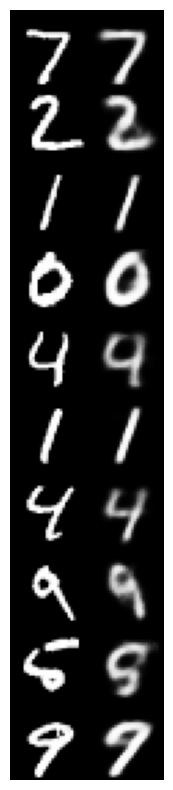

In [16]:
n = 10  # figure with 10 x 2 digits
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size * 2))
decoded = test_pred

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_test[i, :].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()


## g)

In [17]:
# use z_test_pred

In [18]:
from sklearn.manifold import TSNE

In [19]:
# z_test_pred_tsne = z_test_pred[2]

In [20]:
tsne = TSNE(n_components=2)

In [21]:
z_test_pred_tsne = tsne.fit_transform(z_test_pred[2])

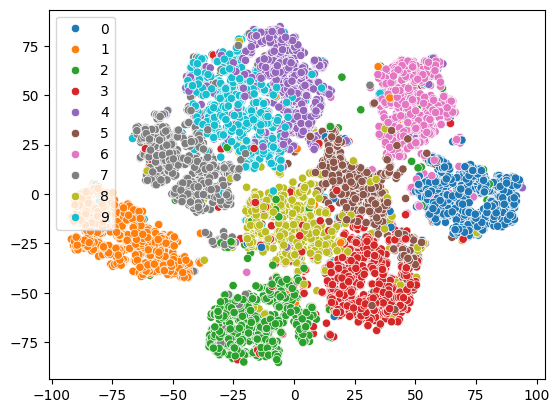

In [22]:
N=10000
sns.scatterplot(x=z_test_pred_tsne[:N,0], y=z_test_pred_tsne[:N,1], hue=y_test[:N], palette=sns.color_palette("tab10"))
plt.show()

In [ ]:
# h) Generate new samples (new images of digits) from your trained VAE. To get new samples you have to
# sample from the prior distribution p(z) and then from the likelihood p(x|z)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


(-0.5, 27.5, 279.5, -0.5)

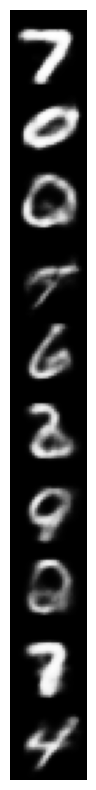

In [32]:
# sample from standard normal 10 z from standard normal

z_sample = np.random.normal(size=(10, latent_dim))

# decode the samples
x_decoded = vae.decoder.predict(z_sample)

# plot the decoded samples
n = 10  # figure with 10 x 2 digits
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))

figure = np.zeros((digit_size * n, digit_size))
decoded = x_decoded

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = decoded[i, :].reshape(digit_size, digit_size)

plt.imshow(figure, cmap='Greys_r')
plt.axis('off')


# TASK 2 - cVAE

In [116]:
# cvae encoder

latent_dim = 10

encoder_inputs = keras.Input(shape=(original_dim+1,))
x = Dense(256, activation='relu')(encoder_inputs)
x = Dense(256, activation='tanh')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
cvae_encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
cvae_encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 785)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 256)       │    201,216 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 256)       │     65,792 │ dense_35[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 10)        │      2,570 │ dense_36[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 10)        │      2,570 │ dense_36[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_10         │ (None, 10)        │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 272,148 (1.04 MB)

 Trainable params: 272,148 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

In [117]:
#cvae decoder

latent_inputs = keras.Input(shape=(latent_dim+1,))
x = Dense(256, activation='relu')(latent_inputs)
x = Dense(256, activation='tanh')(x)
decoder_outputs = Dense(original_dim, activation='sigmoid')(x)
cvae_decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
cvae_decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 11)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 270,352 (1.03 MB)

 Trainable params: 270,352 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

In [118]:
@tf.function
def elbo_vae(x, x_decoded, z_mean, z_log_var):

    loss_term = tf.reduce_sum(x * tf.math.log(x_decoded + 1e-19) + (1 - x) * tf.math.log(1 - x_decoded + 1e-19), 1)

    KL_term =  0.5 * tf.reduce_sum(-z_log_var + tf.exp(z_log_var) + tf.square(z_mean) - 1, 1)

    return tf.reduce_mean(loss_term - KL_term)

In [119]:
class cVAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def train_step(self, data):
       
        
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            cl = data[:, -1]
            cl = cl[:, None]
            x = data[:, :-1]
            reconstruction = self.decoder(tf.concat([z, cl], 1))
            total_loss = -elbo_vae(x, reconstruction, z_mean, z_log_var)           

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)

        return {"loss": self.total_loss_tracker.result()}        



In [120]:
# train model

cvae = cVAE(cvae_encoder, cvae_decoder)
cvae.compile(optimizer=keras.optimizers.Adam())

# prepare data with concatenated labels

x_train_c = tf.concat([x_train, tf.cast(y_train[:, None], float)], 1)

# fit 
cvae.fit(x_train_c, epochs=25, batch_size=256)


Epoch 1/25


235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 246.7415 - total_loss: 198.9708
Epoch 2/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 157.2933 - total_loss: 151.5546
Epoch 3/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 137.9420 - total_loss: 136.2361
Epoch 4/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 130.2588 - total_loss: 129.3038
Epoch 5/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 124.0882 - total_loss: 123.6763
Epoch 6/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 120.4084 - total_loss: 119.9908
Epoch 7/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 117.4977 - total_loss: 117.3410
Epoch 8/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 115.2764 - total_loss: 115.4199
Epoch 9/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 113.6619 - total_loss: 113.8607
Epoch 10/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 112.3862 - total_loss: 112.6225
Epoch 11/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 111.2352 - total_l

In [121]:
# pred on test

z_test_pred = cvae.encoder.predict(tf.concat([x_test, tf.cast(y_test[:, None], float)], 1))

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [122]:
test_pred = cvae.decoder.predict(tf.concat([z_test_pred[2], tf.cast(y_test[:, None], float)], 1))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


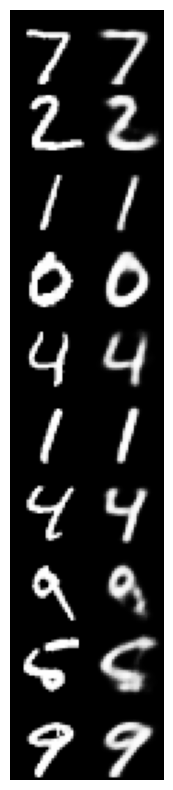

In [123]:
# draw images

n = 10  # figure with 10 x 2 digits
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size * 2))
decoded = test_pred

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_test[i, :].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, digit_size:] = decoded[i, :].reshape(digit_size, digit_size)

plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()

In [124]:
# do tsne

z_test_pred_tsne = tsne.fit_transform(z_test_pred[2])


<Axes: >

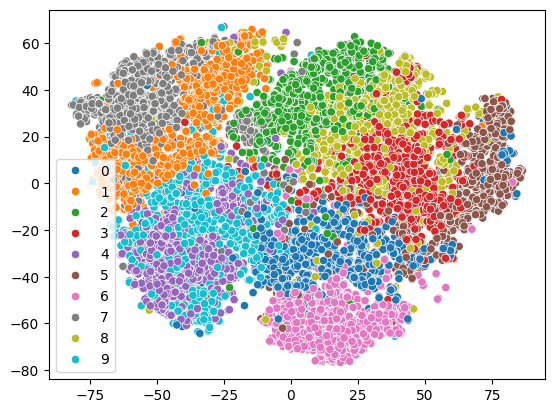

In [125]:
# plot tsne

N=10000

sns.scatterplot(x=z_test_pred_tsne[:N,0], y=z_test_pred_tsne[:N,1], hue=y_test[:N], palette=sns.color_palette("tab10"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


(-0.5, 27.5, 279.5, -0.5)

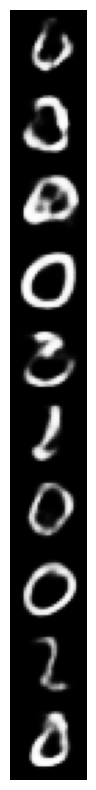

In [130]:
# sample from prior

z_sample = np.random.normal(size=(10, latent_dim))

# decode the samples

x_decoded = cvae.decoder.predict(tf.concat([z_sample, np.zeros(10)[:, None]], 1))

# plot the decoded samples

n = 10  # figure with 10 x 2 digits
digit_size = (np.sqrt(original_dim)).astype('int')

fig = plt.figure(figsize=(10, 10))

figure = np.zeros((digit_size * n, digit_size))
decoded = x_decoded

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = decoded[i, :].reshape(digit_size, digit_size)

plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
